In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import os
from astropy.timeseries import LombScargle 
from jdcal import gcal2jd
from CosinorPy import cosinor, cosinor1

In [17]:
def data_orgaziner(file_name):

    col_names = ["Index", "DateD", "DateM", "DateY", "Time", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused", "Light"]
    
    for i in range(1, 33):
        col_names.append(f"Sp{i}")
    
    folder_path = 'Data'
    file_name = 'StA LD-DD 0118-0201-2024.txt'
    file_path = os.path.join(folder_path, file_name)
    
    df = pd.read_csv(file_path, names=col_names, sep='\s+', header=None)
    df = df.set_index('Index')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
    deleted_data = df[df["MonStatus"] != 1]
    print(f"Removed rows of data where Monitor Status is not 1: {len(deleted_data)}\n")
    df = df[df["MonStatus"] == 1]
    
    
    month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    df['DateM'] = df['DateM'].str[:3].map(month_map)
    df['DateY'] = df['DateY'].apply(lambda x: int(str(20) + str(x)))
    df['Date'] = pd.to_datetime(dict(year=df['DateY'], month=df['DateM'], day=df['DateD']), errors='coerce')
    
    df['Time'] = pd.to_datetime(dict(year=df['Date'].dt.year,
                                         month=df['Date'].dt.month,
                                         day=df['Date'].dt.day,
                                         hour=df['Time'].dt.hour,
                                         minute=df['Time'].dt.minute,
                                         second=df['Time'].dt.second))
    
    df = df.drop(["DateD", "DateM", "DateY", "Date", "MonStatus", "Extras", "MonN", "TubeN", "DataType", "Unused"], axis=1)
    
    day_map = {day: idx+1 for idx, day in enumerate(df['Time'].dt.day.unique())}
    
    df.insert(0, 'Day', df['Time'].dt.day.map(day_map))
    
    spiders = []
    
    for i in range(1, 33):
        if df[f"Sp{i}"].sum() > 5:
            spiders.append(i)
        if not i in spiders:
            df = df.drop([f"Sp{i}"], axis=1)

    return df, spiders

def naming_pattern(file_name):
    group_name = file_name.split(' ', 2)[0]
    light_condition = file_name.split(' ', 2)[1]
    start_date = file_name.split(' ', 2)[2].split('-', 1)[0]
    
    path = group_name + "_" + light_condition + "_" + start_date
    
    two_lights = False
    if "-" in light_condition:
        #li_con_1, li_con_2 = light_condition.split('-', 1)
        two_lights = True

    return group_name, light_condition, start_date, path, two_lights

In [19]:
file_name = 'StA LD-DD 0118-0201-2024.txt'

df, spiders = data_orgaziner(file_name)

display(df)

group_name, light_condition, start_date, path, two_lights = naming_pattern(file_name)

Removed rows of data where Monitor Status is not 1: 0



,Day,Time,Light,Sp3,Sp4,Sp5,Sp6,Sp7,Sp9,Sp10,...,Sp15,Sp16,Sp17,Sp18,Sp19,Sp21,Sp22,Sp23,Sp24,Sp25
Index,,,,,,,,,,,,,,,,,,,,,
1,1,2024-01-18 13:17:00,1,15,9,12,10,17,11,6,...,5,8,5,10,11,5,4,6,6,4
2,1,2024-01-18 13:18:00,1,0,0,1,0,1,1,0,...,1,0,1,4,0,0,0,1,0,0
3,1,2024-01-18 13:19:00,1,0,0,1,0,2,4,0,...,6,0,2,0,0,0,0,3,0,20
4,1,2024-01-18 13:20:00,1,0,4,3,0,1,0,0,...,4,0,1,1,0,0,0,0,0,9
5,1,2024-01-18 13:21:00,1,0,3,3,0,0,0,0,...,2,0,3,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20417,15,2024-02-01 17:33:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20418,15,2024-02-01 17:34:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20419,15,2024-02-01 17:35:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Light code

In [21]:
def light_code(df):
    LL_days = []
    LD_days = []
    
    for j in range(1, len(df['Day'].unique()) + 1):
        curr_df = df[df['Day']==j]
    
        if curr_df['Light'].sum() > 0:
            if curr_df['Light'].sum() > 1000:
                LL_days.append(j)
            else:
                LD_days.append(j)
    
    condition_days = {}
    
    condition_days['LD'] = LD_days
    
    condition_days['DD'] = [x for x in df['Day'].unique() if not x in LL_days and not x in LD_days]
    
    condition_days['LL'] = LL_days
    
    
    """
    if two_lights:
        name_wrong = li_con_1 == 
        
    if light_condition == 
    
    li_con_1, li_con_2
    """
    
    condition_keys = [key for key in condition_days if condition_days[key]]

    return condition_days, condition_keys
    


In [23]:
condition_days, condition_keys = light_code(df)
print(condition_days)

{'LD': [1, 2, 3, 4, 5, 6, 7], 'DD': [8, 9, 10, 11, 12, 13, 14, 15], 'LL': []}


# Raster Plot Code

In [25]:
def raster_plot_2(sp, fig, light_con):
    for j in condition_days[light_con]:
        curr_df = df[df['Day']==j]

        curr_df_avg = curr_df.groupby(curr_df['Time'].dt.hour)[sp].mean()
    
        ax = fig.add_subplot(len(df['Day'].unique()), 1, j)
        ax.set_ylabel(f"Day {j}", rotation="horizontal", va="center", ha="right", fontsize=8)

        
        for k in range(0, len(curr_df) -1):
            start_time = curr_df['Time'].iloc[k]
            end_time = curr_df['Time'].iloc[k + 1]
            if curr_df['Light'].iloc[k] == 1:
                ax.axvspan(start_time.hour + start_time.minute / 60, end_time.hour + end_time.minute / 60, color='yellow', alpha=0.3)

        curr_df_avg.plot.bar(y = [sp], ax=ax)
        
        ax.set_ylim(0, 1)
        ax.legend().remove()
        ax.tick_params(left=False, bottom=False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlim(-0.5, 23.5)
        ax.set_xlabel("")
        
        if j == condition_days[light_con][0]:
            ax.set_title(f"{group_name} {sp.split('p', 2)[1]}")
            #ax.text(0.5, 1.5, x, fontsize=12, horizontalalignment='center', transform=ax.transAxes)
            
        if j == len(df["Day"].unique()):
            ax.set_xticks(np.arange(0, 25, 2))
            ax.set_xticklabels(np.arange(0, 25, 2), rotation = 'horizontal', fontsize = 7)
            ax.set_xlabel('Time (hours)')
        

    """
    file_path = os.path.join(raster_path, f"{group_name}_{sp.split('p', 2)[1]}_{light_condition}_{start_date}_raster_plot.png")
    plt.savefig(file_path)
    """
    #plt.close()
    plt.show()

In [27]:
def raster_plot(sp, fig, light_con):
    for j in condition_days[light_con]:
        curr_df = df[df['Day']==j]

        #curr_df_avg = curr_df.groupby(curr_df['Time'].dt.hour)[sp].mean()
    
        ax = fig.add_subplot(len(df['Day'].unique()), 1, j)
        ax.set_ylabel(j, rotation="horizontal", va="center", ha="right", fontsize=8)

        
        for k in range(0, len(curr_df) -1):
            start_time = curr_df['Time'].iloc[k]
            end_time = curr_df['Time'].iloc[k + 1]
            if curr_df['Light'].iloc[k] == 1:
                ax.axvspan(start_time.hour * 60 + start_time.minute, end_time.hour * 60 + end_time.minute, color='yellow', alpha=0.3)

        curr_df.plot.bar(y = [sp], ax=ax)
        
        ax.set_ylim(0, 5)
        ax.legend().remove()
        ax.tick_params(left=False, bottom=False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlim(-0.5, 1440.5)
        ax.set_xlabel("")
        
        if j == condition_days[light_con][0]:
            ax.set_title(f"{group_name} {sp.split('p', 2)[1]}")
            #ax.text(0.5, 1.5, x, fontsize=12, horizontalalignment='center', transform=ax.transAxes)
            
        if j == len(df["Day"].unique()):
            ax.set_xticks(np.arange(0, 25, 2))
            ax.set_xticklabels(np.arange(0, 25, 2), rotation = 'horizontal', fontsize = 7)
            ax.set_xlabel('Time (hours)')
        

    """
    file_path = os.path.join(raster_path, f"{group_name}_{sp.split('p', 2)[1]}_{light_condition}_{start_date}_raster_plot.png")
    plt.savefig(file_path)
    """
    #plt.close()
    plt.show()

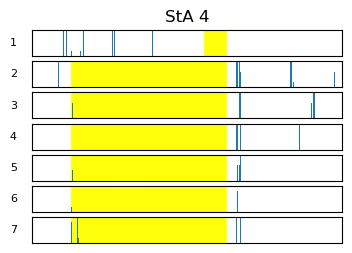

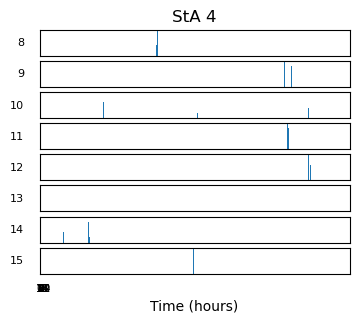

'\n\nfor light in condition_keys:\n    for i in spiders:\n        fig = plt.figure(figsize=(4, 6))\n        raster_plot(f"Sp{i}", fig, light)\n\n\n\n'

In [74]:
raster_path = path + "_raster_plots"

if not os.path.exists(raster_path):
    os.makedirs(raster_path)


x = "Sp4"

fig1 = plt.figure(figsize=(4, 6))
raster_plot(x, fig1, 'LD')

fig2 = plt.figure(figsize=(4, 6))
raster_plot(x, fig2, 'DD')

"""

for light in condition_keys:
    for i in spiders:
        fig = plt.figure(figsize=(4, 6))
        raster_plot(f"Sp{i}", fig, light)



"""


In [130]:
def datetime_to_jd(dt):
    year, month, day = dt.year, dt.month, dt.day
    hour, minute, second = dt.hour, dt.minute, dt.second
    _, jd = gcal2jd(year, month, day)
    jd += (hour + minute / 60 + second / 3600) / 24
    return jd


# value, display, save, dis+save

def period_LS(df, sp, light_con, result_type='value'):
    if result_type != 'value' and result_type != 'display' and result_type != 'save' and result_type != 'dis+save':
        print("The 'result_type' parameter only takes in 'value', 'display', 'save', 'dis+save'.")
        return None
    
    first_day = condition_days[light_con][0]
    last_day = condition_days[light_con][-1]
    
    curr_df = df[(df["Day"] >= first_day) & (df["Day"] <= last_day)]

    activity = np.array(curr_df[sp])
    time = curr_df['Time'].apply(datetime_to_jd)

    ls = LombScargle(time, activity)
    freq = np.linspace(0.5, 2, len(activity))
    power = ls.power(freq)
    
    max_power = np.max(power)
    max_freq = freq[np.argmax(power)]

    periods = 1 / freq * 24
    power_new = power.copy()

    """
    
    while max_freq > 1.9 or max_freq < 0.75:
        max_power_indices = np.where(power_new == max_power)[0]
        power_new = np.delete(power_new, max_power_indices)
        #periods = np.delete(periods, max_power_indices)
        
        max_power = np.max(power_new)
        max_freq = freq[np.argmax(power_new)]

    """
    
    period = 1 / max_freq
    period *= 24
    #print(f"The Lomb-Scargle approximation of the period is {period} hours.")

    if result_type != 'value':
        plt.figure(figsize=(10, 6))
        plt.plot(periods, power)
        plt.scatter(period, max_power, s=75, c="red")
        plt.xlabel('Period (hours)')
        plt.ylabel('Power')
        plt.xlim(12, 36)
        plt.xticks(np.arange(12, 37, 2))
        plt.title(f'Lomb-Scargle Periodogram for {group_name} {sp.split("p", 2)[1]}')
        
        if result_type == 'display':
            plt.show()

        if result_type == 'save':
            file_path = os.path.join(LS_path, f"LS_{group_name}_{sp.split('p', 2)[1]}_{light_condition}_{start_date}.png")
            plt.savefig(file_path)
            plt.close()

        if result_type == 'dis+save':
            file_path = os.path.join(LS_path, f"LS_{group_name}_{sp.split('p', 2)[1]}_{light_condition}_{start_date}.png")
            plt.savefig(file_path)
            plt.show()

    return period



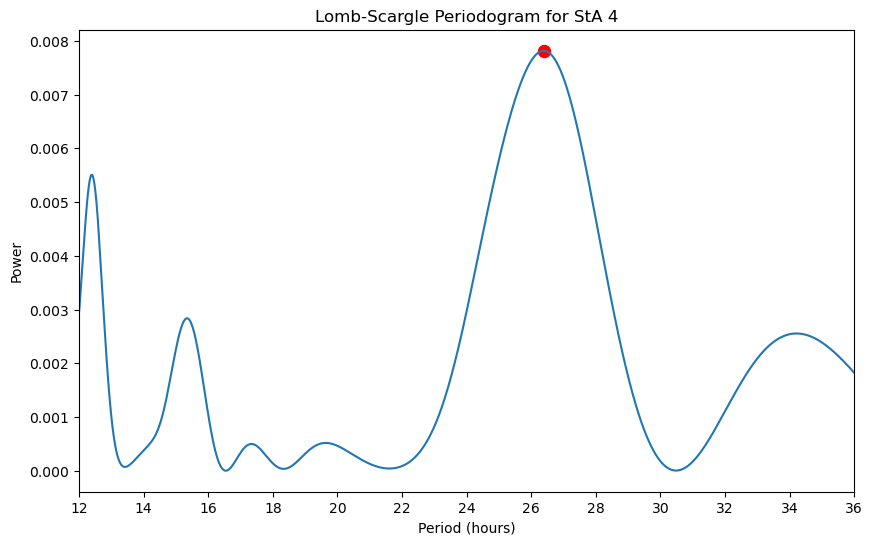

Sp4 DD   26.3857847976308 





'\n\nLS_period_approx = period_LS(df, x, \'DD\', \'display\')\nprint(x, \'DD\', " ", LS_period_approx)\n\nfor light in condition_keys:\n    for i in spiders:\n        LS_period_approx = period_LS(df, f"Sp{i}", \'LD\', \'value\')\n        print(i, light, " ", LS_period_approx)\n\n'

In [132]:
LS_path = "LS_" + path

if not os.path.exists(LS_path):
    os.makedirs(LS_path)



x = "Sp4"
LS_period_approx = period_LS(df, x, 'DD', 'display')
print(x, 'DD', " ", LS_period_approx, "\n\n\n")


"""

LS_period_approx = period_LS(df, x, 'DD', 'display')
print(x, 'DD', " ", LS_period_approx)

for light in condition_keys:
    for i in spiders:
        LS_period_approx = period_LS(df, f"Sp{i}", 'LD', 'value')
        print(i, light, " ", LS_period_approx)

"""


# Cosinor Period Estimate: Built in Version 

In [17]:
import CosinorPy

In [19]:
from CosinorPy import cosinor_nonlin
def cosinor_period_approx(df, sp):
    X = df['Time'].apply(datetime_to_jd).values
    Y = df[sp].values

    popt_ext, statistics, statistics_params = cosinor_nonlin.fit_generalized_cosinor(X,Y, period=None, min_per = 5, max_per=36, plot=True, plot_margins=False, save_to = "", x_label="time [h]", y_label="measurements", test="", hold_on=False, color="black")
    period_approx = statistics_params['params']['period']
    print(popt_ext, statistics, statistics_params)
    print('The approximated period is:', period_approx)

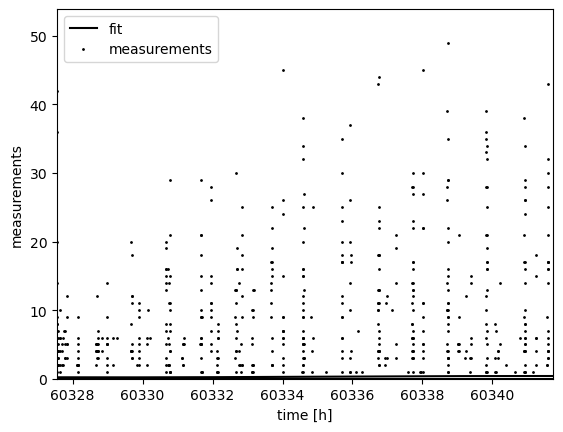

[ 4.05682027e-01  1.00582633e-01 -5.15590690e-07 -1.80094773e-06
  1.08626731e-02  2.40020927e+01] {'p': 0.0009959499410326922, 'p_reject': 1.1102230246251565e-16, 'SNR': 0.031698219576786826, 'RSS': 108738.55000775655, 'resid_SE': 2.30790047550527, 'ME': 4.523670011011291} {'params': {'A': 0.40568202711201984, 'B': 0.1005826328139494, 'C': -5.155906904952669e-07, 'D': -1.8009477274482337e-06, 'acrophase': 0.010862673145296143, 'period': 24.002092697826725}, 'p_values': {'A': 0.9997955804836369, 'B': 0.999978676344105, 'C': 0.9999993369681446, 'D': 0.9999452542652549, 'acrophase': 0.9999703322669655, 'period': 0.0}, 'CIs': {'A': [-3103.2389583808936, 3104.050322435118], 'B': [-7376.731827521747, 7376.932992787374], 'C': [-1.2161284263469165, 1.2161273951655354], 'D': [-0.051448723560530894, 0.051445121665076], 'acrophase': [-572.6017804075574, 572.623505753848], 'period': [23.12424646405239, 24.87993893160106]}}
The approximated period is: 24.002092697826725


In [21]:
cosinor_period_approx(df, 'Sp25')

# Cosinor Period Approximation: Periodogram Version

In [23]:
#nonlinear cosinor model for period estimate 
from CosinorPy import cosinor_nonlin
from scipy import signal

def cosinor_period_approx_2(df, sp):
    X = df['Time'].apply(datetime_to_jd).values
    Y = df[sp].values
    _, _, statistics_params_basic = cosinor_nonlin.fit_cosinor_basic(X, Y, period=None)
    initial_period = statistics_params_basic['params']['period']
    initial_period_ci = statistics_params_basic['CIs']['period']
    
    # Step 2: Compute the periodogram and identify the dominant period
    frequency, power = LombScargle(X, Y).autopower()
    best_frequency = frequency[np.argmax(power)]
    best_period = 1 / best_frequency
    
    # Step 3: Refine the period estimate using fit_generalized_cosinor
    popt_ext, statistics, statistics_params = cosinor_nonlin.fit_generalized_cosinor(X, Y, period=best_period)
    
    # Print the results
    print("Initial Period Estimate (fit_cosinor_basic):", initial_period)
    print("Initial Period Confidence Interval:", initial_period_ci)
    print("Dominant Period from Periodogram:", best_period)
    print("Refined Period Estimate (fit_generalized_cosinor):", popt_ext[-1])

In [25]:
cosinor_period_approx_2(df, 'Sp25')

Initial Period Estimate (fit_cosinor_basic): 24.002088514737206
Initial Period Confidence Interval: [-1.3224576455799308, 49.32663467505434]
Dominant Period from Periodogram: 0.0003473421420116825
Refined Period Estimate (fit_generalized_cosinor): 0.0003473421420116825


/home/af34660a-87c9-4e82-9a65-44776fda5495/.local/lib/python3.10/site-packages/CosinorPy/cosinor_nonlin.py:132: RuntimeWarning: invalid value encountered in scalar divide
  T0 = popt[i]/perr[i]


# CSV dataframe

In [27]:
data_report = pd.DataFrame(columns=['Group', 'SpiderN', 'Period', 'Date'])

group_info = [group_name for i in range(len(spiders))]

data_report['Group'] = group_info

data_report['SpiderN'] = spiders

#for i, data in enumerate(new_data):
#    df.loc[len(df)] = [group_list[i]] + data[1:]

data_report

#period_LS(df, 'Sp17', 1, 7)

,Group,SpiderN,Period,Date
0,StA,3,NaN,NaN
1,StA,4,NaN,NaN
2,StA,5,NaN,NaN
3,StA,6,NaN,NaN
4,StA,7,NaN,NaN
5,StA,9,NaN,NaN
6,StA,10,NaN,NaN
7,StA,11,NaN,NaN
8,StA,12,NaN,NaN
9,StA,13,NaN,NaN


# Raster plot separator

In [49]:
"""

raster plot: LD/DD/LL separation 
user must manually put in day range and LD/LL/DD (may automate second part later)
Parameters that I changed: first day that you would like to select (inclusive), last 

"""
def raster_separate(first_day, last_day, expr_type, sp, fig):
    
    for j in range(first_day, last_day + 1):
        curr_df = df[df['Day']==j]
        #display(curr_df[200:205])
        
        curr_df_avg = curr_df.groupby(curr_df['Time'].dt.hour)[sp].mean()
    
        ax = fig.add_subplot(last_day + 1, 1, j)
        ax.set_ylabel(f"Day {j}", rotation="horizontal", va="center", ha="right", fontsize=8)

        
        for k in range(0, len(curr_df) -1):
            start_time = curr_df['Time'].iloc[k]
            end_time = curr_df['Time'].iloc[k + 1]
            if curr_df['Light'].iloc[k] == 1:
                ax.axvspan(start_time.hour + start_time.minute / 60, end_time.hour + end_time.minute / 60, color='yellow', alpha=0.3)

        curr_df_avg.plot.bar(y = [sp], ax=ax)
        
        ax.set_ylim(0, 1)
        ax.legend().remove()
        ax.tick_params(left=False, bottom=False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xlim(-0.5, 23.5)
        ax.set_xlabel("")
        
        if j == first_day:
            ax.set_title(sp)
            #ax.text(0.5, 1.5, x, fontsize=12, horizontalalignment='center', transform=ax.transAxes)
            
        if j == last_day:
            ax.set_xticks(np.arange(0, 25, 2))
            ax.set_xticklabels(np.arange(0, 25, 2), rotation = 'horizontal', fontsize = 7)
            ax.set_xlabel('Time (hours)')

    if not os.path.exists("Raster_plots"):
            os.makedirs("Raster_plots")
    
    file_path = os.path.join("Raster_plots", f"{sp}_raster_plot_{expr_type}.png")
    plt.savefig(file_path)
    #plt.close()
    plt.show()

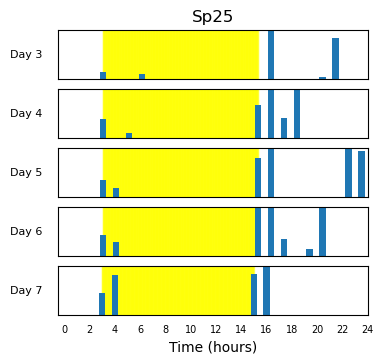

In [53]:
for i in range(25, 26):
    x = f"Sp{i}"
    fig = plt.figure(figsize=(4, 6))
    raster_separate(3, 7, "DD", x, fig)